In [ ]:
#!pip install rapidfuzz # Нужно для Colab
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from rapidfuzz import fuzz, process # Мощный поиск схожих названий
from datetime import datetime
from functools import lru_cache
import requests
import os
from folium.features import CustomIcon
from matplotlib.patches import Wedge
import numpy as np
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
import math

# Словарь для хранения важных рабочих английских названий столбцов
column_names = {
    "region": "region",
    "year": "year",
    "geo_poz": "geo_poz",
}

available_data = []
combined_data_df = None
geojson_data = None
map_parameters = {}
header_mapping = {}

# Функция для загрузки файлов
def load_data_files(source_choice, geojson_url=None, csv_url=None):
    default_geojson_path = 'Voronezh_region.geojson'
    default_csv_path = 'combined_table.csv'
    custom_folder = 'custom_files'
    default_geojson_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/json/Voronezh_region.geojson'
    default_csv_url = 'https://raw.githubusercontent.com/Dimatron74/foliumVRN/refs/heads/main/combined_table.csv'

    # Создаем папку для пользовательских файлов, если она не существует
    if not os.path.exists(custom_folder):
        os.makedirs(custom_folder)

    def download_from_url(file_path, url):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                # Открываем файл в режиме записи ('wb'), чтобы перезаписать его, если он уже существует
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"Файл {file_path} успешно загружен с {url}")
            else:
                print(f"Ошибка при загрузке {file_path}: HTTP {response.status_code}")
        except Exception as e:
            print(f"Ошибка при загрузке {file_path}: {str(e)}")

    if source_choice == '1':
        # Загрузка стандартных файлов
        download_from_url(default_geojson_path, default_geojson_url)
        download_from_url(default_csv_path, default_csv_url)
        return default_geojson_path, default_csv_path

    elif source_choice == '2':
        # Загрузка пользовательских файлов
        final_geojson_path = default_geojson_path
        final_csv_path = default_csv_path

        # Обработка URL для GeoJSON
        if geojson_url and geojson_url.strip():
            custom_geojson_path = os.path.join(custom_folder, 'custom_Voronezh_region.geojson')
            download_from_url(custom_geojson_path, geojson_url)
            final_geojson_path = custom_geojson_path
        else:
            # Если URL для GeoJSON не предоставлен, используем стандартный файл
            download_from_url(default_geojson_path, default_geojson_url)

        # Обработка URL для CSV
        if csv_url and csv_url.strip():
            custom_csv_path = os.path.join(custom_folder, 'custom_combined_table.csv')
            download_from_url(custom_csv_path, csv_url)
            final_csv_path = custom_csv_path
        else:
            # Если URL для CSV не предоставлен, используем стандартный файл
            download_from_url(default_csv_path, default_csv_url)

        return final_geojson_path, final_csv_path

    else:
        # Загрузка стандартных файлов по умолчанию
        download_from_url(default_geojson_path, default_geojson_url)
        download_from_url(default_csv_path, default_csv_url)
        return default_geojson_path, default_csv_path

# Чтение данных
def read_data(geojson_path, csv_path):
    global combined_data_df, geojson_data
    # Чтение CSV
    combined_data_df = pd.read_csv(csv_path, sep=None, encoding='utf-8-sig', header=[0, 1], engine='python', decimal=',', thousands='\xa0')
    english_headers = combined_data_df.columns.get_level_values(0).str.lower()
    russian_headers = combined_data_df.columns.get_level_values(1)
    global header_mapping
    header_mapping = dict(zip(english_headers, russian_headers))
    combined_data_df.columns = english_headers
    combined_data_df[column_names["region"]] = combined_data_df[column_names["region"]].str.strip().str.lower().str.replace('ё', 'е')
    global available_data
    available_data = [col for col in combined_data_df.columns if col not in [column_names["region"], column_names["year"]]]
    # Чтение GeoJSON
    with open(geojson_path, 'r', encoding='utf-8') as f:
        geojson_data = json.load(f)

# Интерфейс ipywidgets для выбора источника данных
def create_data_source_interface():
    source_selection = widgets.RadioButtons(
        options=[('Стандартные файлы', '1'), ('Свои файлы', '2')],
        description='Выбор источника:',
        disabled=False
    )

    custom_geojson_url = widgets.Text(description="GeoJSON URL:", value='')
    custom_csv_url = widgets.Text(description="CSV URL:", value='')

    load_button = widgets.Button(description="Загрузить данные")
    output = widgets.Output()

    data_source_box = widgets.VBox([
        source_selection,
        widgets.HTML(value="<b>Шаг 1: Выбор источника данных</b><br>Выберите способ загрузки данных."),
        widgets.HBox([custom_geojson_url, custom_csv_url], layout=widgets.Layout(display='none'))
    ])

    def toggle_url_fields(change):
        if change['new'] == '2':
            data_source_box.children[-1].layout.display = 'flex'
        else:
            data_source_box.children[-1].layout.display = 'none'

    source_selection.observe(toggle_url_fields, names='value')

    def load_data(b):
        with output:
            output.clear_output()
            try:
                source_choice = source_selection.value
                geojson_url = custom_geojson_url.value.strip() if source_choice == '2' else None
                csv_url = custom_csv_url.value.strip() if source_choice == '2' else None
                geojson_path, csv_path = load_data_files(source_choice, geojson_url, csv_url)
                read_data(geojson_path, csv_path)
                print("Данные успешно загружены!")
            except Exception as e:
                print("Ошибка при загрузке данных:", str(e))

    load_button.on_click(load_data)

    display(
        widgets.VBox([
            data_source_box,
            load_button,
            output
        ])
    )

# Запуск виджета подгрузки файлов
create_data_source_interface()


# Ссылка на гугл таблицу для удобства тестирования
# https://docs.google.com/spreadsheets/d/1igd267153bI1D16peIcQcy0COusxtuFt2vdyDDEiMx8/export?format=csv&gid=0


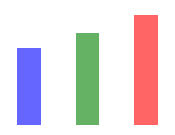
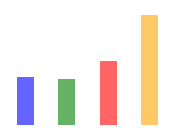
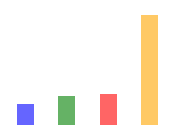
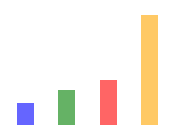
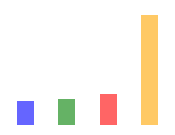
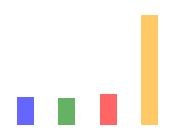
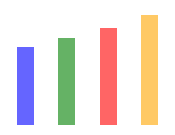
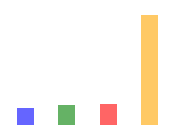
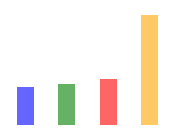
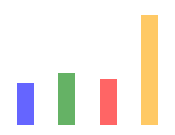
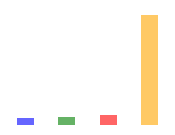
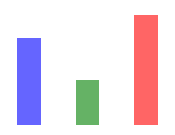
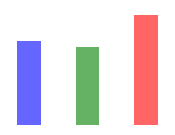
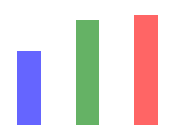
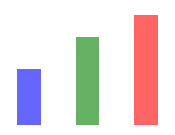
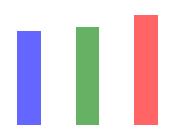
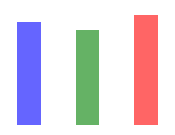
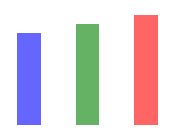
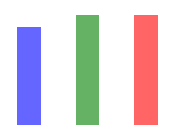
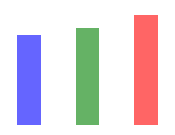
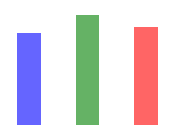
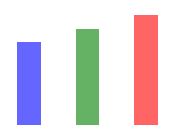
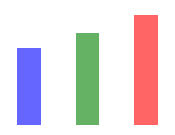
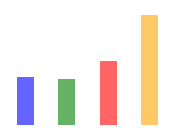
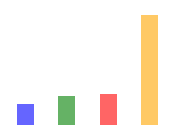
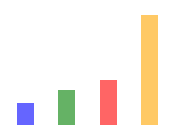
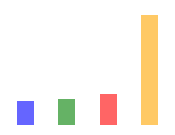
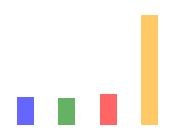
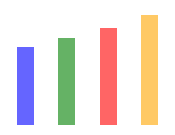
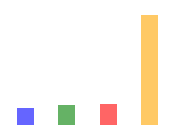
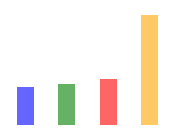
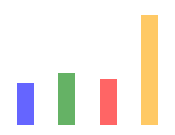
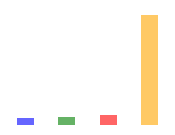
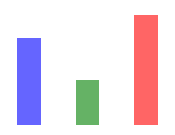
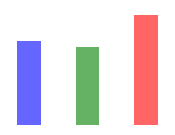
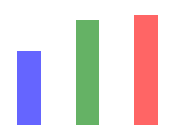
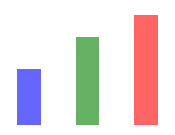
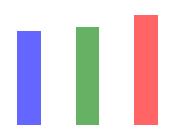
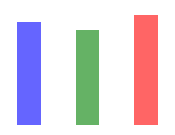
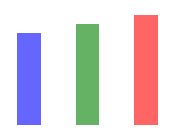
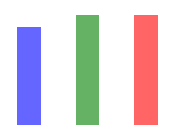
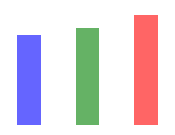
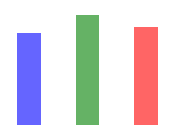
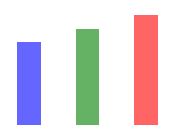


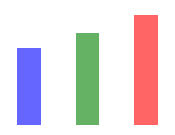
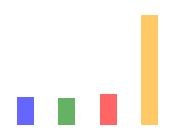
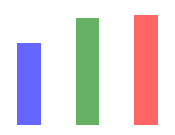
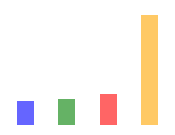
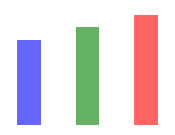
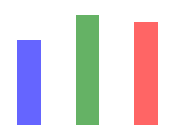
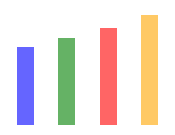
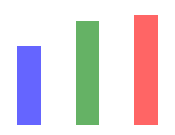
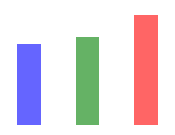
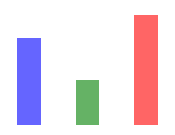
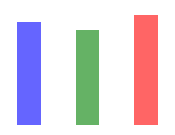
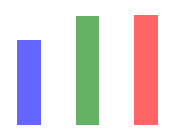
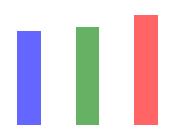
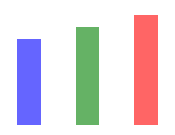
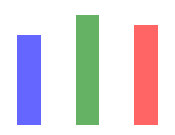
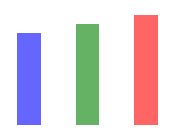
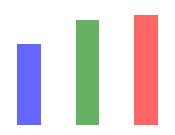
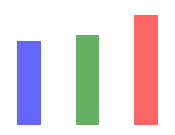

In [30]:
# Создание интерфейса для выбора параметров карты
def create_map_parameters_interface():
    # Проверяем, есть ли поле "geo_poz" в CSV
    has_geo_poz = column_names["geo_poz"] in combined_data_df.columns
    global geo_poz_russian_name
    geo_poz_russian_name = get_russian_name(column_names["geo_poz"]) if has_geo_poz else None

    # Чекбоксы для выбора типа данных
    map_type_checkboxes = []
    for option in [("GeoJSON районы", "geojson"), ("Населенные пункты (OpenStreetMap)", "osm")]:
        checkbox = widgets.Checkbox(
            value=False,  # По умолчанию чекбоксы не выбраны
            description=option[0]
        )
        map_type_checkboxes.append(checkbox)
    
    # Добавляем чекбокс для "geo_poz", если поле существует
    if has_geo_poz:
        geo_poz_checkbox = widgets.Checkbox(
            value=False,
            description=geo_poz_russian_name  # Используем русское название
        )
        map_type_checkboxes.append(geo_poz_checkbox)

    map_types_box = widgets.VBox(map_type_checkboxes)
    lat_input = widgets.FloatText(value=51.67, description='Широта:', disabled=False)
    lon_input = widgets.FloatText(value=39.18, description='Долгота:', disabled=False)
    zoom_input = widgets.IntSlider(value=8, min=1, max=18, step=1, description='Zoom:')
    
    # Новый шаг 3: Выбор типа маркеров (выпадающий список)
    marker_type_selection = widgets.Dropdown(
        options=[('Стандартные', 'standard'), ('Столбчатая диаграмма', 'bar'),
                 ('Круговая диаграмма', 'pie'), ('Круговые маркеры', 'circle')],
        description='Тип маркеров:',
        disabled=False,
        layout=widgets.Layout(display='none')  # Скрываем по умолчанию
    )
    
    column_checkboxes = []
    for column in available_data:
        # Исключаем "geo_poz" из списка доступных столбцов, если оно есть
        if column == column_names["geo_poz"]:
            continue
        checkbox = widgets.Checkbox(
            value=False,  # По умолчанию чекбоксы не выбраны
            description=get_russian_name(column)
        )
        column_checkboxes.append(checkbox)
    columns_box = widgets.VBox(column_checkboxes)
    
    years = sorted(combined_data_df[column_names["year"]].unique())
    year_checkboxes = []
    for year in years:
        checkbox = widgets.Checkbox(
            value=bool(year == max(years)),  # Только последний год выбран по умолчанию
            description=str(year)
        )
        year_checkboxes.append(checkbox)
    years_box = widgets.VBox(year_checkboxes, layout=widgets.Layout(display='none'))  # Скрываем по умолчанию
    
    # Заголовки для шагов 3, 4 и 5
    step_5_title = widgets.HTML(value="<b>Шаг 5: Выбор типа маркеров</b><br>Выберите тип маркеров для отображения данных населённых пунктов.", layout=widgets.Layout(display='none'))
    step_4_title = widgets.HTML(value="<b>Шаг 4: Выбор года отображения</b><br>Выберите год(ы), данные за который будут показаны.", layout=widgets.Layout(display='none'))
    status_label = widgets.Label(value="")
    confirm_button = widgets.Button(description="Подтвердить параметры")
    
    def toggle_visibility(change):
        # Проверяем, выбран ли тип данных "Населенные пункты (OpenStreetMap)"
        is_osm_selected = any(cb.value and (cb.description == "Населенные пункты (OpenStreetMap)" or cb.description == geo_poz_russian_name) for cb in map_type_checkboxes)
        # Управляем видимостью шагов 3, 4 и 5
        marker_type_selection.layout.display = 'flex' if is_osm_selected else 'none'
        years_box.layout.display = 'flex' if is_osm_selected else 'none'
        # Управляем видимостью заголовков шагов 3, 4 и 5
        step_4_title.layout.display = 'block' if is_osm_selected else 'none'
        step_5_title.layout.display = 'block' if is_osm_selected else 'none'
    
    for checkbox in map_type_checkboxes:
        checkbox.observe(toggle_visibility, names='value')
    
    def confirm_parameters(b):
        selected_map_types = [cb.description for cb in map_type_checkboxes if cb.value]
        selected_lat = float(lat_input.value)
        selected_lon = float(lon_input.value)
        selected_zoom = int(zoom_input.value)
        
        # Получаем выбранные русские названия столбцов
        selected_columns_ru = [cb.description for cb in column_checkboxes if cb.value]
        # Преобразуем русские названия в английские
        selected_columns_en = []
        for ru_name in selected_columns_ru:
            en_name = next((k for k, v in header_mapping.items() if v == ru_name), None)
            if en_name:
                selected_columns_en.append(en_name)
            else:
                print(f"Предупреждение: Не удалось найти английское название для '{ru_name}'")
        
        selected_years = [int(cb.description) for cb in year_checkboxes if cb.value]
        selected_marker_type = marker_type_selection.value
        
        print("Выбранные параметры создания карты:")
        print(f"- Типы данных: {', '.join(selected_map_types) or 'Нет'}")
        print(f"- Координаты: ({selected_lat}, {selected_lon})")
        print(f"- Zoom: {selected_zoom}")
        print(f"- Тип маркеров: {selected_marker_type}")
        print(f"- Выбранные столбцы (рус): {', '.join(selected_columns_ru) or 'Нет'}")
        print(f"- Выбранные столбцы (англ): {', '.join(selected_columns_en) or 'Нет'}")
        print(f"- Год(ы): {', '.join(map(str, selected_years))}")
        
        global map_parameters
        map_parameters = {
            "map_types": selected_map_types,
            "center": [selected_lat, selected_lon],
            "zoom": selected_zoom,
            "columns": selected_columns_en,  # Сохраняем английские названия столбцов
            "years": selected_years,
            "marker_type": selected_marker_type
        }
        
        # Показываем статус создания карты
        status_label.value = "Создание карты... Пожалуйста, подождите."
        # Переходим к созданию карты
        try:
            create_final_map()
            status_label.value = f"Карта успешно создана и сохранена по пути: final_map.html"
        except Exception as e:
            status_label.value = f"Ошибка при создании карты: {str(e)}"
    
    confirm_button.on_click(confirm_parameters)
    
    display(
        widgets.VBox([
            widgets.HTML(value="<b>Шаг 1: Выбор типа данных для построения карты</b><br>Выберите источник данных для карты."),
            map_types_box,
            widgets.HTML(value="<b>Шаг 2: Установка геокоординат</b><br>Введите начальные координаты и масштаб карты."),
            widgets.HBox([lat_input, lon_input]),
            zoom_input,
            widgets.HTML(value="<b>Шаг 3: Выбор столбцов для отображения</b><br>Выберите данные, которые будут отображаться на карте."),
            columns_box,
            step_4_title,
            years_box,
            step_5_title,
            marker_type_selection,
            confirm_button,
            status_label
        ])
    )

# Функции обработки данных
def get_russian_name(english_name):
    return header_mapping.get(english_name, english_name)

# Функция для получения данных о населённых пунктах с OpenStreetMap
def fetch_settlements_from_overpass():
    print("Получение данных о населённых пунктах с OpenStreetMap...")
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = """
    [out:json][timeout:25];
    area["name"="Воронежская область"]["admin_level"="4"]->.region;
    (
      node["place"](area.region);
    );
    out body;
    >;
    out skel qt;
    """
    response = requests.post(overpass_url, data=overpass_query)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Ошибка при запросе к Overpass API: {response.status_code}")
        return None

# Функция для обработки данных о населённых пунктах
def process_settlements_data(settlements_data, combined_data_df):
    """Обрабатывает данные о населённых пунктах, добавляя население из CSV."""
    settlements = []
    
    # Если выбран тип данных "geo_poz"
    if geo_poz_russian_name in map_parameters.get("map_types", []):
        for _, row in combined_data_df.iterrows():
            geo_poz = row.get(column_names["geo_poz"])
            if geo_poz:
                try:
                    lat, lon = map(float, str(geo_poz).split(","))
                    print(lat, lon)
                    settlement_name = row.get(column_names["region"], "Unknown").strip().lower().replace('ё', 'е')
                    settlements.append({
                        "name": settlement_name.capitalize(),
                        "lat": lat,
                        "lon": lon,
                    })
                except ValueError:
                    print(f"Ошибка при разборе координат: {geo_poz}")
    else:
        # Обработка данных из OSM
        if settlements_data:
            for element in settlements_data.get("elements", []):
                if element.get("type") == "node" and "tags" in element:
                    tags = element["tags"]
                    settlement_name = tags.get("name", "").strip().lower().replace('ё', 'е')
                    lat = element.get("lat")
                    lon = element.get("lon")
                    match = find_matching_region(settlement_name, combined_data_df[column_names["region"]].unique())
                    if match:
                        settlements.append({
                            "name": settlement_name.capitalize(),
                            "lat": lat,
                            "lon": lon,
                        })
    return settlements


# Функции создания диаграмм для маркеров населённых пунктов
def create_bar_chart_icon(settlement, grouped_data, data_type, selected_years):
    data_values = grouped_data.get(data_type, {})
    years = [str(year) for year in selected_years if str(year) in data_values]

    # Проверяем, можно ли преобразовать значения в float
    values = []
    for year in years:
        try:
            value = float(data_values[year])
            if pd.isna(value):  # Пропускаем NaN значения
                continue
            values.append(value)
        except ValueError:
            continue  # Пропускаем значения, которые нельзя преобразовать

    if not years or not values:  # Если нет данных для построения графика
        return None

    plt.figure(figsize=(2, 1.5))
    if len(years) == 1:
        positions = [-1, 0, 1]
        bar_values = [0, values[0], 0]
        colors = ['white', 'gray' if values[0] > 0 else 'blue', 'white']
        plt.bar(positions, bar_values, width=0.4, color=colors, alpha=0.6)
        plt.xticks([0], years, fontsize=6, rotation=45)
    else:
        plt.bar(range(len(years)), values, width=0.4,
                color=['blue', 'green', 'red', 'orange', 'purple'][:len(years)], alpha=0.6)
        plt.xticks(range(len(years)), years, fontsize=6, rotation=45)
    plt.yticks(fontsize=6)
    plt.axis('off')
    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight', transparent=True)
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()
    return CustomIcon(f"data:image/png;base64,{image_base64}", icon_size=(50, 50))

def create_pie_chart_icon(settlement, grouped_data, data_type, selected_years):
    data_values = grouped_data.get(data_type, {})
    years = [str(year) for year in selected_years if str(year) in data_values]

    # Проверяем, можно ли преобразовать значения в float
    values = []
    for year in years:
        try:
            value = float(data_values[year])
            if pd.isna(value):  # Пропускаем NaN значения
                continue
            values.append(value)
        except ValueError:
            continue

    if not years or not values:
        return None

    total = sum(values) if values else 1
    percentages = [value / total * 100 if total > 0 else 0 for value in values]
    color_list = ['blue', 'green', 'red', 'orange', 'purple']
    fig, ax = plt.subplots(figsize=(1, 1), dpi=100)
    fig.patch.set_alpha(0)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    start_angle = 0
    colors = ['gray'] if len(years) == 1 and values[0] > 0 else color_list[:len(years)]
    for i, percentage in enumerate(percentages):
        wedge = Wedge((0, 0), 1, start_angle, start_angle + percentage * 3.6,
                      facecolor=colors[i], edgecolor='black', alpha=0.5)
        ax.add_patch(wedge)
        start_angle += percentage * 3.6
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    img = Image.fromarray(image)
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return CustomIcon(f"data:image/png;base64,{img_base64}", icon_size=(50, 50))



# Функции создания маркеров населённых пунктов
def add_bar_chart_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue

        # Получаем данные за выбранные годы
        data_values = grouped_data.get(data_type, {})
        years = [str(year) for year in map_parameters["years"] if str(year) in data_values]

        # Проверяем, можно ли преобразовать значения в float
        values = []
        for year in years:
            try:
                value = float(data_values[year])
                if pd.isna(value):  # Пропускаем NaN значения
                    continue
                values.append(value)
            except ValueError:
                continue
        if not values or all(v == 0 for v in values):
            continue

        tooltip_text = f"{settlement['name']}<br>"
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br><br>"
        popup_html += f"Данные <b>{get_russian_name(data_type)}</b> по годам:<br>"
        for year, value in zip(years, values):
            tooltip_text += f"{year}: {value}<br>"
            popup_html += f"<b>{year}:</b> {value}<br>"

        icon = create_bar_chart_icon(settlement, grouped_data, data_type, map_parameters["years"])
        if icon:
            folium.Marker(
                location=[settlement["lat"], settlement["lon"]],
                icon=icon,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=folium.Tooltip(tooltip_text)
            ).add_to(layer)

def add_pie_chart_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue

        # Получаем данные за выбранные годы
        data_values = grouped_data.get(data_type, {})
        years = [str(year) for year in map_parameters["years"] if str(year) in data_values]

        # Проверяем, можно ли преобразовать значения в float
        values = []
        for year in years:
            try:
                value = float(data_values[year])
                if pd.isna(value):  # Пропускаем NaN значения
                    continue
                values.append(value)
            except ValueError:
                continue

        if not values or all(v == 0 for v in values):
            continue

        tooltip_text = f"{settlement['name']}<br>"
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br><br>"
        popup_html += f"Данные <b>{get_russian_name(data_type)}</b> по годам:<br>"
        for year, value in zip(years, values):
            tooltip_text += f"{year}: {value}<br>"
            popup_html += f"<b>{year}:</b> {value}<br>"

        icon = create_pie_chart_icon(settlement, grouped_data, data_type, map_parameters["years"])
        if icon:
            folium.Marker(
                location=[settlement["lat"], settlement["lon"]],
                icon=icon,
                popup=folium.Popup(popup_html, max_width=300),
                tooltip=folium.Tooltip(tooltip_text)
            ).add_to(layer)

def add_standard_markers(settlements, layer, data_type):
    for settlement in settlements:
        region_name, grouped_data = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue

        # Получаем данные за выбранные годы
        data_values = grouped_data.get(data_type, {})
        years = [str(year) for year in map_parameters["years"] if str(year) in data_values]

        # Проверяем, можно ли преобразовать значения в float
        values = []
        for year in years:
            try:
                value = float(data_values[year])
                if pd.isna(value):  # Пропускаем NaN значения
                    continue
                values.append(value)
            except ValueError:
                continue

        if not values:
            continue

        max_year = max([int(year) for year in years])  # Находим максимальный год
        max_value = data_values.get(str(max_year), 0)  # Получаем значение для этого года

        tooltip_text = f"{settlement['name']} ({max_year}: {max_value})"
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br><br>"
        popup_html += f"Данные <b>{get_russian_name(data_type)}</b> по годам:<br>"
        for year, value in zip(years, values):
            popup_html += f"<b>{year}:</b> {value}<br>"

        folium.Marker(
            location=[settlement["lat"], settlement["lon"]],
            tooltip=tooltip_text,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(layer)

def add_circle_markers(settlements, layer, data_type):
    min_value = combined_data_df[data_type].min()
    max_value = combined_data_df[data_type].max()

    for settlement in settlements:
        region_name, grouped_data = get_settlement_data(settlement, data_type)
        if not region_name:
            print(f"Соответствие не найдено для {settlement['name']}")
            continue

        # Получаем данные за выбранные годы
        data_values = grouped_data.get(data_type, {})
        years = [str(year) for year in map_parameters["years"] if str(year) in data_values]

        # Проверяем, можно ли преобразовать значения в float
        values = []
        for year in years:
            try:
                value = float(data_values[year])
                if pd.isna(value):  # Пропускаем NaN значения
                    continue
                values.append(value)
            except ValueError:
                continue

        total_value = sum(values) if values else 0

        if total_value == 0 or max_value == min_value:
            radius = 5  # Минимальный размер для нулевых или одинаковых значений
        else:
            log_min = math.log1p(min_value)
            log_max = math.log1p(max_value)
            log_value = math.log1p(total_value)
            normalized_value = (log_value - log_min) / (log_max - log_min)
            radius = 5 + normalized_value * (50 - 5)
            radius = min(max(radius, 5), 50)  # Ограничиваем размеры

        tooltip_text = f"{settlement['name']}<br>"
        popup_html = f"<b>Населённый пункт:</b> {settlement['name']}<br><br>"
        popup_html += f"Данные <b>{get_russian_name(data_type)}</b> по годам:<br>"
        for year, value in zip(years, values):
            tooltip_text += f"{year}: {value}<br>"
            popup_html += f"<b>{year}:</b> {value}<br>"

        if total_value == 0:
            tooltip_text += "Данные отсутствуют<br>"
            popup_html += "Данные отсутствуют<br>"

        folium.CircleMarker(
            location=[settlement["lat"], settlement["lon"]],
            radius=radius,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=folium.Popup(popup_html, max_width=300),
            tooltip=folium.Tooltip(tooltip_text)
        ).add_to(layer)


def add_markers_based_on_type(settlements, layer, data_type, marker_type):
    if marker_type == 'bar':
        add_bar_chart_markers(settlements, layer, data_type)
    elif marker_type == 'pie':
        add_pie_chart_markers(settlements, layer, data_type)
    elif marker_type == 'circle':
        add_circle_markers(settlements, layer, data_type)
    else:
        add_standard_markers(settlements, layer, data_type)





def group_columns_by_year(df, region_name):
    region_data = df[df[column_names["region"]] == region_name]
    grouped_data = {}
    data_columns = [col for col in df.columns if col not in [column_names["region"], column_names["year"]]]
    for col in data_columns:
        grouped_data[col] = {}
        for _, row in region_data.iterrows():
            year = str(row[column_names["year"]])
            value = row[col]
            # Проверка на NaN
            if not pd.isna(value):  # Убедитесь, что значение не NaN
                grouped_data[col][year] = value
    return grouped_data

def get_closest_year_value(grouped_data, column, current_year):
    if column not in grouped_data or not grouped_data[column]:
        return None
    years = list(grouped_data[column].keys())
    values = list(grouped_data[column].values())
    if not years:
        return None
    closest_year = min(years, key=lambda y: abs(int(y) - current_year))
    return float(values[years.index(closest_year)])

def find_matching_region(target, candidates):
    target_normalized = target.strip().lower().replace('ё', 'е')
    if target_normalized in candidates:
        return target_normalized
    match = process.extractOne(target_normalized, candidates, scorer=fuzz.token_set_ratio, score_cutoff=85)
    if match:
        best_match = match[0]
        if any(best_match != candidate and best_match in candidate for candidate in candidates):
            return None
        return best_match
    return None

def create_chart(region_name, grouped_data, column):
    group_name = get_russian_name(column)
    if group_name == column:
        print(f"Предупреждение: Русское название не найдено для '{column}'.")

    if column not in grouped_data or not grouped_data[column]:
        return None

    years = []
    values = []

    # Собираем данные только если есть корректные значения
    for year, value in grouped_data[column].items():
        if pd.isna(value):  # Пропускаем NaN значения
            continue
        try:
            year_int = int(year)
            value_float = float(value)
            years.append(year_int)
            values.append(value_float)
        except ValueError:
            continue  # Пропускаем некорректные значения

    if not years or not values:
        return None

    plt.figure(figsize=(3, 2))

    # Проверяем, достаточно ли данных для построения линии тренда
    if len(years) > 1:
        bars = plt.bar(years, values, color=['blue', 'green', 'red'], alpha=0.6, label=group_name)
        plt.plot(years, values, color='black', marker='o', linewidth=2, label='Тренд')

        # Добавляем значения над столбцами
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', fontsize=8)
    else:
        # Если данных только для одного года - рисуем один столбец
        bars = plt.bar(years, values, color=['blue'], alpha=0.6, label=group_name)
        yval = values[0]
        plt.text(years[0], yval + 0.5, f"{yval:.1f}", ha='center', va='bottom', fontsize=8)

    plt.title(f'{group_name}\n{region_name}', fontsize=10)
    plt.xlabel('Год', fontsize=8)
    plt.ylabel(group_name, fontsize=8)
    plt.xticks(years, fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)

    buffer = BytesIO()
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image_base64 = base64.b64encode(buffer.read()).decode('utf-8')
    plt.close()

    return f'<img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">'

# Функция стиля для GeoJSON
def style_function(feature):
    district_name = feature['properties']['district'].lower().replace('ё', 'е')
    match, chart_html = process_district_data(district_name)
    if match:
        popup_html = create_popup_html(district_name.capitalize(), chart_html)
        feature['properties']['popup_html'] = popup_html
    return {
        'fillColor': "grey",
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.1
    }

# Функция для создания единого HTML для всплывающего окна у районов
def create_popup_html(district_name, chart_html):
    html_template = f"""
    <div style="width: 100%; max-width: 800px; height: auto; margin: 0 auto; border: 1px solid #ddd; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); overflow: hidden; font-family: Arial, sans-serif;">
        <div style="padding: 15px; background-color: #f9f9f9; border-bottom: 1px solid #ddd;">
            <h3 style="margin: 0; font-size: 18px; color: #333;">Район: {district_name}</h3>
        </div>
        <div style="padding: 15px; display: flex; flex-direction: column; align-items: center; max-height: 350px; min-width: 300px; overflow-y: auto; background-color: #fff;">
            {chart_html if chart_html else "<p style='color: #888; text-align: center;'>Данные отсутствуют</p>"}
        </div>
    </div>
    """
    return html_template

@lru_cache(maxsize=None)
def process_district_data(district_name):
    match = find_matching_region(district_name, combined_data_df[column_names["region"]].unique())
    if not match:
        return None, "Данные отсутствуют"
    grouped_data = group_columns_by_year(combined_data_df, match)
    charts = []

    # Фильтруем столбцы по выбранным пользователем
    selected_columns = map_parameters.get("columns", [])
    for column in selected_columns:  # Используем только выбранные столбцы
        if column not in grouped_data:
            continue
        is_numeric = True
        for year, value in grouped_data[column].items():
            if pd.isna(value):  # Пропускаем NaN значения
                continue
            try:
                float(value)
            except ValueError:
                is_numeric = False
                break
        if is_numeric:
            chart = create_chart(match, grouped_data, column)
            if chart:
                charts.append(chart)

    chart_html = ' '.join(charts) if charts else "Данные отсутствуют"
    return match, chart_html

# Универсальная функция для получения данных о населённом пункте
def get_settlement_data(settlement, data_type):
    settlement_name = settlement['name'].lower().replace('ё', 'е')
    region_name = find_matching_region(settlement_name, combined_data_df[column_names["region"]].unique())
    if region_name:
        grouped_data = group_columns_by_year(combined_data_df, region_name)
        values = {}
        for year in map_parameters["years"]:
            value = grouped_data.get(data_type, {}).get(str(year))
            try:
                values[year] = float(value) if value is not None else 0
            except ValueError:
                values[year] = value
        # total_value = sum(values.values()) if values else 0 # Было нужно, но теперь не нужно
        return region_name, grouped_data
    return None, None



# Создание финальной карты
def create_final_map():
    center = map_parameters["center"]
    zoom = map_parameters["zoom"]
    selected_marker_type = map_parameters.get("marker_type", "standard")
    selected_map_types = map_parameters.get("map_types", [])
    m = folium.Map(location=center, zoom_start=zoom)
    
    # Добавление слоев базовой карты
    base_maps = {
        "OpenStreetMap": folium.TileLayer("OpenStreetMap"),
        "CartoDB Positron": folium.TileLayer("CartoDB Positron", show=False),
        "CartoDB Dark_Matter": folium.TileLayer("CartoDB Dark_Matter", show=False)
    }
    for name, layer in base_maps.items():
        layer.add_to(m)
    
    # Добавление слоя GeoJSON районов
    if "GeoJSON районы" in selected_map_types:
        district_layer = folium.FeatureGroup(name="Районы", show=True)
        folium.GeoJson(
            geojson_data,
            style_function=style_function,
            tooltip=folium.GeoJsonTooltip(fields=['district'], aliases=['Район:'], localize=True),
            popup=folium.GeoJsonPopup(fields=['popup_html'], aliases=[None], localize=True, labels=False, parse_html=True, max_width=800),
        ).add_to(district_layer)
        district_layer.add_to(m)
    
    # Добавление слоев населенных пунктов
    settlements_geo_poz = []
    settlements_osm = []
    
    # Обработка данных из CSV (geo_poz)
    if geo_poz_russian_name in selected_map_types:
        settlements_geo_poz = process_settlements_data(None, combined_data_df)  # Передаем None для settlements_data
    
    # Обработка данных из OSM
    if "Населенные пункты (OpenStreetMap)" in selected_map_types:
        settlements_data = fetch_settlements_from_overpass()
        if settlements_data:
            settlements_osm = process_settlements_data(settlements_data, combined_data_df)
    
    # Добавление маркеров для geo_poz
    if settlements_geo_poz:
        for data_type in map_parameters["columns"]:
            layer_name = f"{get_russian_name(data_type)} ({geo_poz_russian_name})"
            layer = folium.FeatureGroup(name=layer_name, show=False)
            add_markers_based_on_type(settlements_geo_poz, layer, data_type, selected_marker_type)
            layer.add_to(m)
    
    # Добавление маркеров для OSM
    if settlements_osm:
        for data_type in map_parameters["columns"]:
            layer_name = f"{get_russian_name(data_type)} (Населенные пункты)"
            layer = folium.FeatureGroup(name=layer_name, show=False)
            add_markers_based_on_type(settlements_osm, layer, data_type, selected_marker_type)
            layer.add_to(m)
    
    # Добавление контроля слоев
    folium.LayerControl().add_to(m)
    
    # Сохранение карты
    output_map_path = 'final_map.html'
    m.save(output_map_path)
    print(f"Карта успешно сохранена в файл: {output_map_path}")
    display(m)

# Запуск основного виджета (создание карты)
create_map_parameters_interface()

In [ ]:
# Функция для загрузки файла на FTP-сервер
def upload_to_ftp(file_path, ftp_host, ftp_user, ftp_pass, ftp_dir="/"):
    import ftplib
    try:
        # Устанавливаем соединение с FTP-сервером
        with ftplib.FTP(ftp_host) as ftp:
            ftp.login(user=ftp_user, passwd=ftp_pass)
            print(f"Успешно подключено к FTP-серверу: {ftp_host}")

            # Переходим в указанную директорию (по умолчанию корень)
            ftp.cwd(ftp_dir)

            # Открываем файл для загрузки
            with open(file_path, 'rb') as file:
                file_name = os.path.basename(file_path)
                ftp.storbinary(f'STOR {file_name}', file)
                print(f"Файл {file_name} успешно загружен на FTP-сервер в директорию {ftp_dir}")
    except ftplib.all_errors as e:
        print(f"Ошибка при загрузке на FTP: {e}")

def create_ftp_uploader_widget():
    ftp_host_input = widgets.Text(description="FTP хост:", value="", placeholder="example.com")
    ftp_user_input = widgets.Text(description="Имя пользователя:", value="", placeholder="username")
    ftp_pass_input = widgets.Password(description="Пароль:", value="", placeholder="password")
    ftp_dir_input = widgets.Text(description="Директория:", value="/", placeholder="/path/to/directory")
    ftp_status_label = widgets.Label(value="")
    ftp_upload_button = widgets.Button(description="Загрузить на FTP")

    def upload_to_ftp_button_click(b):
        ftp_host = ftp_host_input.value.strip()
        ftp_user = ftp_user_input.value.strip()
        ftp_pass = ftp_pass_input.value.strip()
        ftp_dir = ftp_dir_input.value.strip() or "/"

        if not ftp_host or not ftp_user or not ftp_pass:
            ftp_status_label.value = "Ошибка: Пожалуйста, заполните все поля для FTP."
            return

        try:
            upload_to_ftp('final_map.html', ftp_host, ftp_user, ftp_pass, ftp_dir)
            ftp_status_label.value = "Карта успешно загружена на FTP-сервер."
        except Exception as e:
            ftp_status_label.value = f"Ошибка при загрузке на FTP: {str(e)}"

    ftp_upload_button.on_click(upload_to_ftp_button_click)

    display(
        widgets.VBox([
            widgets.HTML(value="<b>Необязательный шаг: Загрузка на FTP-сервер</b><br>Если хотите загрузить карту на FTP-сервер, нажмите кнопку ниже."),
            widgets.HBox([ftp_host_input, ftp_user_input, ftp_pass_input]),
            ftp_dir_input,
            ftp_upload_button,
            ftp_status_label
        ])
    )

# Запуск виджета загрузки карты на фтп
create_ftp_uploader_widget()